This file is to very the ability of the method to calculate the sample size 
given H0 and H1. 



In [1]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_nlinear_nostd"
DATA = ["AD88_matlab_1-45.pkl", "Ctrl92_matlab_1-45.pkl"]

['AD88_matlab_1-45.pkl', 'Ctrl92_matlab_1-45.pkl']

In [2]:
import sys
sys.path.append("./mypkg")


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

In [4]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.likelihood import obt_lin_tm
from utils.misc import save_pkl, load_pkl

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_dtype(torch.double)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [8]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
df0= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
df1= pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt_more.csv");
df1 = df1.set_index("RID")
df0 = df0.set_index("RID");
df1 = df1.reindex(df0.index)
baseline = df1
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDFP_dev/mypkg/../data/AD_vs_Ctrl_PSD/AD88_matlab_1-45.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDFP_dev/mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_matlab_1-45.pkl


In [9]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = 10*np.log10(raw_X);
outlier_idxs2 = np.where(X_dB.mean(axis=(1, 2))<0)
#X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);
X = X_dB

Y = np.array(baseline["MMSE"])[:X.shape[0]];
# if logi
Yb = np.array(baseline["Grp_binary"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age","Education"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];


outlier_idxs = np.sort(np.union1d(outlier_idxs, outlier_idxs2))


# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Yb = np.delete(Yb, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Yb = Yb[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z = np.concatenate([np.ones((Z_raw.shape[0], 1)), Z_raw], axis=1); # add intercept


freqs = AD_PSD.freqs;
# only take PSD between [2, 35] freqs of interest
X = X[:, :, np.bitwise_and(freqs>=2, freqs<=35)]
X = X/X.mean()


print(X.shape, Y.shape, Z.shape)

all_data = edict()
if SAVED_FOLDER.endswith("X1err"):
    all_data.X = torch.tensor(X+np.random.randn(*X.shape)*0.1)
else:
    all_data.X = torch.tensor(X)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)


(143, 68, 74) (143,) (143, 4)


In [10]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

In [11]:
rois_clean =  """
Bankssts,
Caudal anterior cingulate,
Caudal middle frontal,
Cuneus,
Entorhinal,
Frontal pole,
Fusiform,
Inferior parietal,
Inferior temporal,
Insula,
Isthmus cingulate,
Lateral occipital,
Lateral orbitofrontal,
Lingual,
Medial orbitofrontal,
Middle temporal,
Paracentral,
Parahippocampal,
Pars opercularis,
Pars orbitalis,
Pars triangularis,
Pericalcarine,
Postcentral,
Posterior cingulate,
Precentral,
Precuneus,
Rostral anterior cingulate,
Rostral middle frontal,
Superior frontal,
Superior Parietal,
Superior temporal,
Supramarginal,
Temporal pole,
Transverse temporal
"""
rois_clean_hf = [roi.strip() for roi in rois_clean.split(",")];
rois_clean = ["Left " + roi.lower() for roi in rois_clean_hf] + ["Right " + roi.lower() for roi in rois_clean_hf];

# Param and fns

## Params

In [12]:
from easydict import EasyDict as edict
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from copy import deepcopy
from scenarios.base_params import get_base_params

base_params = get_base_params("linear") 
base_params.data_params = edict()
base_params.data_params.d = all_data.X.shape[1]
base_params.data_params.n = all_data.X.shape[0]
base_params.data_params.npts = all_data.X.shape[-1]
base_params.data_params.freqs = AD_PSD.freqs[np.bitwise_and(freqs>=2, freqs<=35)]

base_params.can_Ns = [4, 6, 8, 10, 12]
base_params.SIS_params = edict({"SIS_pen": 0.02, "SIS_basis_N":8, "SIS_ws":"simpson"})
base_params.opt_params.beta = 10 
base_params.can_lams = [0.60,  0.80,  1,  1.2, 1.4, 1.6, 2.0, 4.0]


setting = edict(deepcopy(base_params))
add_params = edict({})
add_params.setting = "real_data_linear"
add_params.SIS_ratio = 1
setting.update(add_params)

In [13]:
save_dir = RES_ROOT/SAVED_FOLDER
if not save_dir.exists():
    save_dir.mkdir()

In [14]:
bands_cut = edict()
bands_cut.delta = [2, 4]
bands_cut.theta = [4, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

freqs0 = freqs[np.bitwise_and(freqs>=2, freqs<=35)]

cut_pts = np.abs(freqs0.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

array([ 4, 13, 22, 73])

# Analysis

In [15]:
import matplotlib.patches as mpatches
from nilearn import plotting
import matplotlib as mpl
from utils.brain_plot import get_bg_data

In [16]:
def _get_sig_bds(lows, ups):
    """Get sig bds based on lows and ups CI bds
    """
    insig_idxs = np.bitwise_and(lows<=0, ups>=0)
    insig_idxs_num = np.where(insig_idxs)[0]
    idxs = np.where(np.diff(insig_idxs_num)>1)[0]
    bds = [(insig_idxs_num[ix], insig_idxs_num[ix+1]) for ix in idxs]
    if insig_idxs_num[0] > 0:
        bds.append((0, insig_idxs_num[0]))
    if insig_idxs_num[-1] < (len(ups)-1):
        bds.append((insig_idxs_num[-1], len(ups)-1))
    bds = sorted(bds, key=lambda x: x[0])
    return bds

In [17]:

def _brain_plot(vec, cmap="Reds", threshold=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.43
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 10))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    fig.text(0.12, 0.30, 'Medial', ha='center', va='center')
    fig.text(0.12, 0.72, 'Lateral', ha='center', va='center')
    fig.text(0.30, 0.87, 'Left', ha='center', va='center')
    fig.text(0.72, 0.87, 'Right', ha='center', va='center')
    #plt.suptitle("-log pvalues", fontsize=30)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    fig.colorbar(sm, cax=cbar_ax)
    return fig

In [18]:
def _filname2set(fil):
    """Based on the file name, reture the setting"""
    res = edict()
    for curstr in fil.stem.split("-"):
        vs = curstr.split("_")
        if vs[0] == "lam":
            res[vs[0]] = int(vs[1])/1000
        else:
            res[vs[0]] = int(vs[1])
    return res
tNs = []
tlams = []
for fil in save_dir.glob(f"roi_*.pkl"):
    tmp = _filname2set(fil)
    tNs.append(tmp["N"])
    tlams.append(tmp["lam"])
np.sort(np.unique(tNs)),  np.sort(np.unique(tlams))

(array([ 4,  6,  8, 10, 12]), array([0.3, 0.5, 0.7, 0.9, 1.3]))

In [19]:
from utils.misc import get_local_min_idxs
def _argmin_last2d(arr):
    """
    Find the minimum value positions along the last two dimensions of a 2D array.

    Args:
    arr (numpy.ndarray): Input 2D array.

    Returns:
    tuple: Indices of the minimum values along the last two dimensions.
    """
    arr_reshaped = arr.reshape(arr.shape[0], -1)
    min_positions_linear = np.argmin(arr_reshaped, axis=1)
    min_positions = np.unravel_index(min_positions_linear, arr.shape[1:])
    return min_positions
def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]
def _Nlam_localmin(err_mat, Ns, lams):
    min_idxs = []
    for err_vec in err_mat:
        min_idxs.append([_get_min_idx(err_vec), 
                         err_vec[_get_min_idx(err_vec)]])
    min_idxs = np.array(min_idxs)
    best_idx = np.argmin(min_idxs[:, 1])
    best_N = Ns[best_idx]
    best_lam = lams[int(min_idxs[best_idx, 0])]
    return (best_N, best_lam)

In [20]:
from scipy.stats import chi2
lams = np.sort(np.unique(tlams))
lams = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]
Ns = np.array([4, 6, 8, 10, 12])
log_cv = np.log(0.05/68);

In [21]:
errs = load_pkl(RES_ROOT/f"{SAVED_FOLDER}/errs_mse_roi_N_lam.pkl");
errs_dict = {v[0]:v[1] for v in errs};
# sel the lams based on the CV errors
errs_arr = []
for roi_ix in trange(68):
    errs_N = []
    for N in Ns:
        errs_lam = []
        for lam in lams:
            mse = errs_dict[(roi_ix, lam, N)]
            errs_lam.append(mse)
        errs_N.append(errs_lam)
    errs_arr.append(errs_N)
errs_arr = np.array(errs_arr); #nroi x nN x nlam x nsub

Load file /data/rajlab1/user_data/jin/MyResearch/HDFP_dev/mypkg/../results/real_data_nlinear_nostd/errs_mse_roi_N_lam.pkl


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 39000.78it/s]


## Select with mse

In [22]:
sel_Nlams_mse = []
for roi_ix in range(68):
    sel_Nlams_mse.append(_Nlam_localmin(errs_arr[roi_ix], Ns, lams))
sel_Nlams_mse = np.array(sel_Nlams_mse);

save_pkl(RES_ROOT/f"{SAVED_FOLDER}/sel_Nlams_mse.pkl", sel_Nlams_mse)

/data/rajlab1/user_data/jin/MyResearch/HDFP_dev/mypkg/../results/real_data_nlinear_nostd/sel_Nlams_mse.pkl exists! Use is_force=True to save it anyway


In [23]:
T_vs = []
keep_rois = []
pvals = []
for roi_ix in trange(68):
    errs = []
    N, lam = sel_Nlams_mse[roi_ix]
    fil = save_dir/f"roi_{roi_ix}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    hdf_res = load_pkl(fil, verbose=False)
    hdf_res.verbose=1
    test_res = hdf_res.hypo_test(Cmat=np.eye(1))
    T_vs.append(test_res.T_v.item())
    pvals.append(test_res.pval)
    keep_rois.append((hdf_res.est_Gam.norm(dim=0) != 0).numpy().astype(int))
keep_rois = np.array(keep_rois)
T_vs = np.array(T_vs);
pvals = np.array(pvals);

  0%|                                                                                                                             | 0/68 [00:00<?, ?it/s]/home/hujin/jin/conda/envs/HDFP/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full contro

In [35]:
# choose the ROI with the most significant p-value
most_sig_idx = np.argmin(pvals)

64

In [82]:
# get the lobe information
lobs_df =  pd.read_csv(DATA_ROOT/"dk68_utils/DK68_lobe.csv")

lobs_df_names = np.array(lobs_df["name.full"])
lobs = np.array(lobs_df["lobe"])

rawname = lobs_df_names[0]

def _get_cleanname(rawname): 
    """Input the rawname (name from `DK68_lobe.csv`), return the cleaned name
    """
    roi_hemi = "Left" if rawname[0] == "L" else "Right"
    rm_suffix = ["gyrus", "cortex", "lobule"]
    roi_name = rawname[1:]
    for rm_suf in rm_suffix:
        roi_name = roi_name.split(rm_suf)[0].strip()
    if "bank" in roi_name.lower():
        roi_name = "bankssts"
    return f"{roi_hemi} {roi_name}"

# check if the cleaned names are in the rois_clean
if False:
    for rawname in lobs_df_names:
        clname = _get_cleanname(rawname)
        idx = rois_clean.index(clname)
        print(idx)
        if not (clname==rois_clean[idx]):
            print(clname, "not found")

# a dict key is the cleaned name, value is the lobe
roi_lobe_map = dict()
for lob, rawname in zip(lobs, lobs_df_names):
    roi_lobe_map[_get_cleanname(rawname)] = lob

In [88]:
sig_roi_name = list(np.array(rois_clean)[pvals < 0.05/68])
sig_roi_lobe = [roi_lobe_map[roi] for roi in sig_roi_name]
np.unique(sig_roi_lobe, return_counts=True)
pd.DataFrame(np.concatenate([sig_roi_name, sig_roi_lobe], axis=0).reshape(2, -1).T)

,0,1
0,Left cuneus,Occipital
1,Left inferior parietal,Parietal
2,Left inferior temporal,Temporal
3,Left isthmus cingulate,Cingulate
4,Left lingual,Occipital
5,Left middle temporal,Temporal
6,Left pars triangularis,Frontal
7,Left pericalcarine,Occipital
8,Left rostral middle frontal,Frontal
9,Left superior parietal,Parietal


### Calculate the sample size

In [45]:
np.argsort(pvals)

array([31, 59, 29,  7, 63, 47,  3, 37, 55, 41, 13, 21, 60,  8, 15, 10, 42,
       27, 20, 26, 36, 28, 40,  0, 57, 25, 22,  5, 54,  4, 38, 39, 46, 33,
       49,  1, 62, 66, 67, 34, 17, 51, 61,  6, 30, 53, 45, 58,  2, 12, 56,
       19, 44, 11, 35, 43, 18, 48, 52,  9, 24, 32, 23, 50, 65, 16, 14, 64])

In [37]:
rois_clean[31], rois_clean[64]

('Left supramarginal', 'Right superior temporal')

In [47]:
sel_idx = 31

31

In [48]:
fil = save_dir/f"roi_{sel_idx}-lam_{sel_Nlams_mse[sel_idx, 1]*1000:.0f}-N_{sel_Nlams_mse[sel_idx, 0]:.0f}_fit.pkl"
hdf_res = load_pkl(fil, verbose=False);

/home/hujin/jin/conda/envs/HDFP/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [49]:
est_beta, _, _= _get_est_beta(sel_idx);
# let only consider delta and theta band
# ts is under the alternative hypothesis
hs = est_beta.copy()
hs[freqs0>8] = 0


/home/hujin/jin/conda/envs/HDFP/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


/home/hujin/jin/conda/envs/HDFP/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


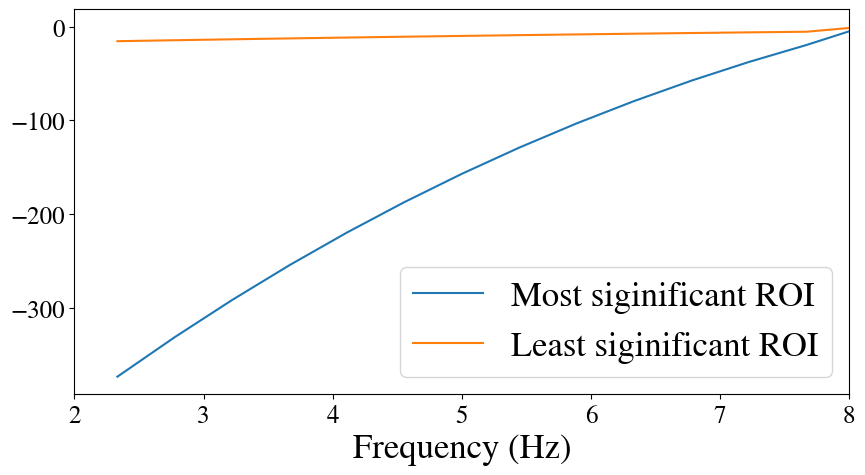

In [62]:
sel_idx = 31
est_beta, _, _= _get_est_beta(sel_idx);
hs1 = est_beta.copy()
hs1[freqs0>8] = 0

sel_idx = 64
est_beta, _, _= _get_est_beta(sel_idx);
hs2 = est_beta.copy()
hs2[freqs0>8] = 0

plt.plot(freqs0, hs1, label="Most siginificant ROI")
plt.plot(freqs0, hs2, label="Least siginificant ROI")
plt.xlim([2, 8])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.savefig(FIG_ROOT/"ssd_hn_most_least_sig_ROI.jpg")

In [55]:
n = hdf_res.det_sample_size(Cmat=np.eye(1), hs=hs, alpha=0.05, power=0.90,nub=10000)

19